In [66]:
import pysam 
import vcf as pyvcf
from pyfasta import Fasta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, integrate
import seaborn as sns
vcf = pyvcf.Reader(open('/home/alexgri/indels/gcat_set_059-ensemble.vcf', 'r'))
ref = Fasta('/home/alexgri/indels/human_g1k_v37.fasta')


In [58]:
def initialize_files():
    vcf = pyvcf.Reader(open('/home/alexgri/indels/gcat_set_059-ensemble.vcf', 'r'))
    ref = Fasta('/home/alexgri/indels/human_g1k_v37.fasta')
chr_dict = {'1':'1 dna:chromosome chromosome:GRCh37:1:1:249250621:1',
            '2':'2 dna:chromosome chromosome:GRCh37:2:1:243199373:1',
            '3':'3 dna:chromosome chromosome:GRCh37:3:1:198022430:1',
            '4':'4 dna:chromosome chromosome:GRCh37:4:1:191154276:1',
            '5':'5 dna:chromosome chromosome:GRCh37:5:1:180915260:1',
            '6':'6 dna:chromosome chromosome:GRCh37:6:1:171115067:1',
            '7':'7 dna:chromosome chromosome:GRCh37:7:1:159138663:1',
            '8':'8 dna:chromosome chromosome:GRCh37:8:1:146364022:1',
            '9':'9 dna:chromosome chromosome:GRCh37:9:1:141213431:1',
            '10':'10 dna:chromosome chromosome:GRCh37:10:1:135534747:1',
            '11':'11 dna:chromosome chromosome:GRCh37:11:1:135006516:1',
            '12':'12 dna:chromosome chromosome:GRCh37:12:1:133851895:1',
            '13':'13 dna:chromosome chromosome:GRCh37:13:1:115169878:1',
            '14':'14 dna:chromosome chromosome:GRCh37:14:1:107349540:1',
            '15':'15 dna:chromosome chromosome:GRCh37:15:1:102531392:1',
            '16':'16 dna:chromosome chromosome:GRCh37:16:1:90354753:1',
            '17':'17 dna:chromosome chromosome:GRCh37:17:1:81195210:1',
            '18':'18 dna:chromosome chromosome:GRCh37:18:1:78077248:1',
            '19':'19 dna:chromosome chromosome:GRCh37:19:1:59128983:1',
            '20':'20 dna:chromosome chromosome:GRCh37:20:1:63025520:1',
            '21':'21 dna:chromosome chromosome:GRCh37:21:1:48129895:1',
            '22':'22 dna:chromosome chromosome:GRCh37:22:1:51304566:1',
            'X':'X dna:chromosome chromosome:GRCh37:X:1:155270560:1',
            'Y':'Y dna:chromosome chromosome:GRCh37:Y:2649521:59034049:1'}

На каждый вызов в этой функции инициализируется массив, а потом проверяются еще условия. Тут легче было бы сделать словарик, или, как это правильно называется, хэш-таблицу. Почитай про dict(). Так ты обойдешься без функций, условий и ускоришь эту часть кода в сотни раз. 
Пофиксил.

In [59]:
def qual():
    initialize_files()
    arr = np.ndarray(0)
    i=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if (len(record.REF)!=1 or len(alt)!=1): 
                arr = np.append(arr, record.QUAL)
    return arr

In [60]:
def count_freq(N):
    initialize_files()
    dfl = pd.DataFrame(columns=range(1,N+1),index = ['A','T','G','C','all']).fillna(float(0))
    dfr = pd.DataFrame(columns=range(1,N+1),index = ['A','T','G','C','all']).fillna(float(0))
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if (len(record.REF)!=1 or len(alt)!=1): 
                chrom = chr_dict[record.CHROM]
                #print record
                #print ref[chrom][record.POS-1-N:record.POS-1+len(record.REF)]
                #print ref[chrom][record.POS-1-N:record.POS-1+len(record.REF)].count(nuc)
                for i in range(1,N+1):
                    for nuc in ['A','T','G','C']:   
                        dfr.loc[nuc,i] += ref[chrom][record.POS+len(record.REF)-1:record.POS-1+len(record.REF)+i].count(nuc)
                        dfl.loc[nuc,i] += ref[chrom][record.POS-1-i:record.POS-1].count(nuc)
                    dfr.loc['all',i] += i
                    dfl.loc['all',i] += i
    for i in range(1,N+1):
        for nuc in ['A','T','G','C']: 
            dfl.loc[nuc,i] /= dfl.loc['all',i]
            dfr.loc[nuc,i] /= dfr.loc['all',i]
    return dfl,dfr
def count_homopolymers():
    initialize_files()
    dfl = pd.DataFrame(columns=range(100),index=range(100)).fillna(0)
    dfr = pd.DataFrame(columns=range(100),index=range(100)).fillna(0)
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if (len(record.REF)!=1 or len(alt)!=1): 
                chrom = chr_dict[record.CHROM]
                i = 1
                char = ref[chrom][record.POS-2]
                while (ref[chrom][record.POS-2-i]==char):
                    i+=1
                dfl.loc[abs(len(record.REF)-len(alt)),i] += 1 
                i = 1
                char = ref[chrom][record.POS+len(record.REF)-1]
                while (ref[chrom][record.POS+len(record.REF)-1+i]==char):
                    i+=1
                dfr.loc[abs(len(record.REF)-len(alt)),i] += 1
    return dfl,dfr


1.Ты сэкономишь процессорное (и свое) время, если будешь считать count_homopolymers_left и count_homopolymers_right за один проход. (в одной функции) В питоне можно возвращаться сразу несколько структур из функции:


def rdf:

    return df1, df2

df_x, df_y = rdf

А еще лучше - для каждого индела в dataframe хранить 2 колонки - количество гомополимеров справа и слева.
Пофиксил
2. строчка while (ref[chrom][record.POS+len(record.REF)-1+i:record.POS+len(record.REF)+i]==ref[chrom][record.POS-1+len(record.REF):record.POS+len(record.REF)]): - нечитаемая. Разве len(record.REF) - это что? В случае делеции - длина делеции (формальная), а в случае инсерции?

Разве нельзя просто обращаться ref[chrom][record.POS+len(record.REF)+i], чтобы получить 1 букву?

Вот это выражение: ref[chrom][record.POS-1+len(record.REF):record.POS+len(record.REF)] - всегда константная строчка, не зависит от i. Зачем ее каждый раз вычислять? Сохрани в отдельную переменную перед циклом. 
Пофиксил.

df.loc[abs(len(record.REF)-len(record.ALT[0])),i] += 1 - не осознал. Разве len(record.ALT[0]) не тождественно равно 1? 
record.ALT это всегда список, в нем может быть и не один элемент, например ref=ATTTTT alt=[ATTTT,ATTT]

In [61]:
quals = qual()

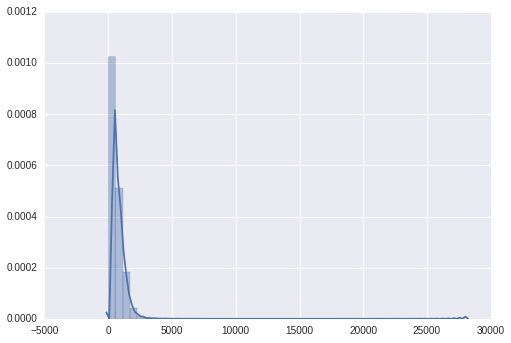

In [65]:
%matplotlib inline
sns.set(color_codes=True)
sns.distplot(quals)

In [67]:
df_left, df_right = count_homopolymers()

In [40]:
print df_left.as_matrix()[1:10,1:10]
print df_right.as_matrix()[1:10,1:10]


[[10053  2747  1001   385   132    40     5     9     3]
 [  255   115    78    30    15     6     1     0     0]
 [   56    20     8     5     4     1     0     0     0]
 [   29     7     1     1     1     0     1     0     0]
 [   17     2     4     0     0     1     2     0     0]
 [    8     2     2     0     0     0     0     0     0]
 [    4     0     0     0     0     0     0     0     0]
 [    5     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0]]
[[3585 1729 2548 2161 1974 1147  558  309  204]
 [ 163   78   92   50   33   10    9    8   17]
 [  44   16    5    4    1    1    0    2    4]
 [  20    4    5    1    7    1    0    0    1]
 [  11    7    5    1    1    0    1    0    0]
 [   6    1    0    1    2    2    0    0    0]
 [   2    1    1    0    0    0    0    0    0]
 [   3    1    0    1    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]]


/home/alexgri/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


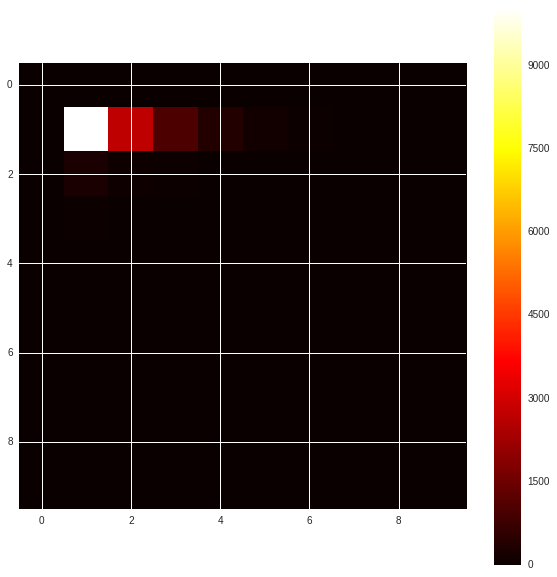

In [41]:
fig = plt.figure(figsize=(10, 10), dpi=500)
plt.imshow(df_left.as_matrix()[:10,:10], cmap='hot', interpolation="nearest")
plt.colorbar()
plt.show()

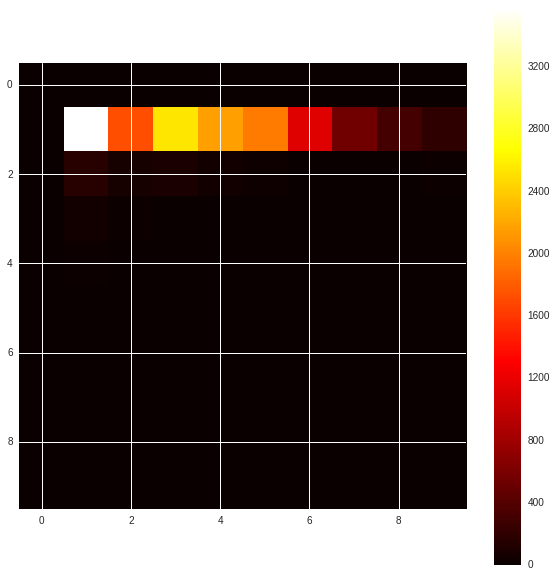

In [42]:
fig = plt.figure(figsize=(10, 10), dpi=500)
plt.imshow(df_right.as_matrix()[:10,:10], cmap='hot', interpolation="nearest")
plt.colorbar()
plt.show()

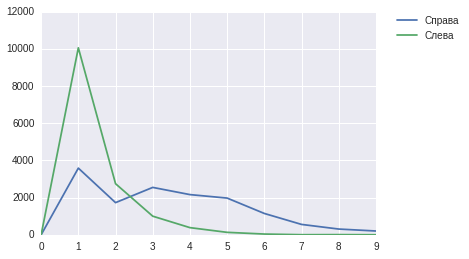

In [43]:
plt.plot(df_right.as_matrix()[1,:10],label=u"Справа")
plt.plot(df_left.as_matrix()[1,:10],label=u"Слева")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

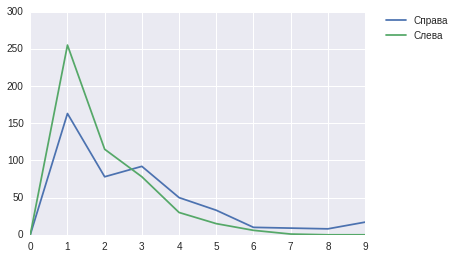

In [44]:
plt.plot(df_right.as_matrix()[2,:10],label=u"Справа")
plt.plot(df_left.as_matrix()[2,:10],label=u"Слева")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [167]:
freq_left, freq_right = count_freq(10)

KeyboardInterrupt: 

In [ ]:
print freq_left
print freq_right

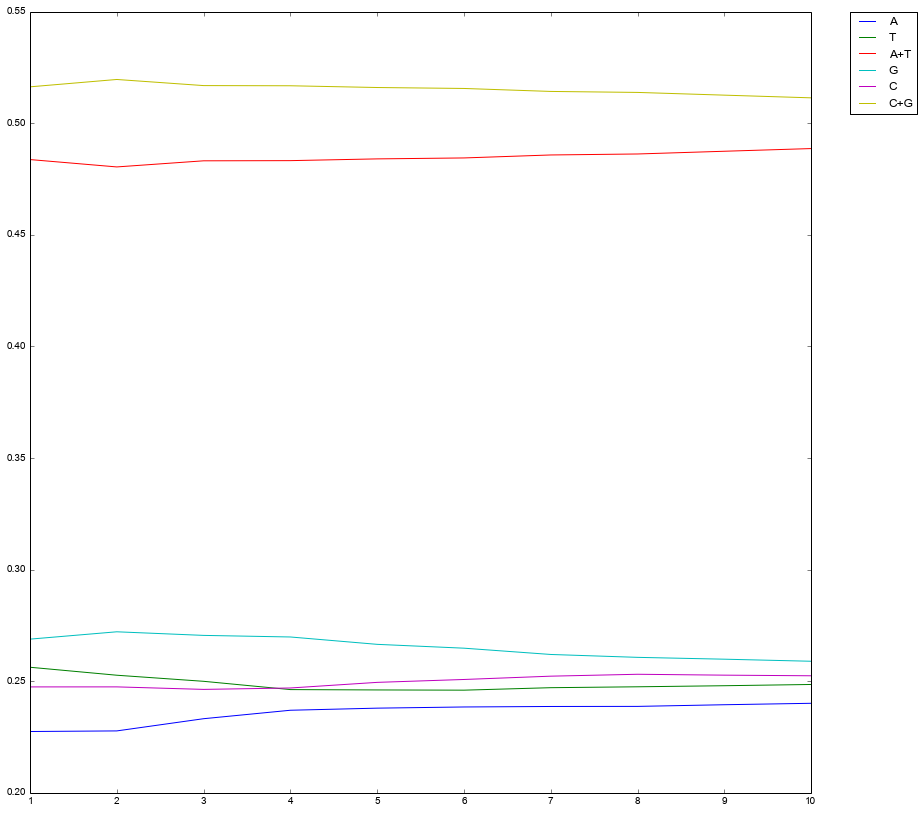

In [302]:
plt.figure(figsize=(14, 14), dpi=500)
plt.plot(np.arange(10)+1,freq_left_A,label=u"A")
plt.plot(np.arange(10)+1,freq_left_T,label=u"T")
plt.plot(np.arange(10)+1,freq_left_T+freq_left_A,label=u"A+T")
plt.plot(np.arange(10)+1,freq_left_G,label=u"G")
plt.plot(np.arange(10)+1,freq_left_C,label=u"C")
plt.plot(np.arange(10)+1,freq_left_C+freq_left_G,label=u"C+G")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

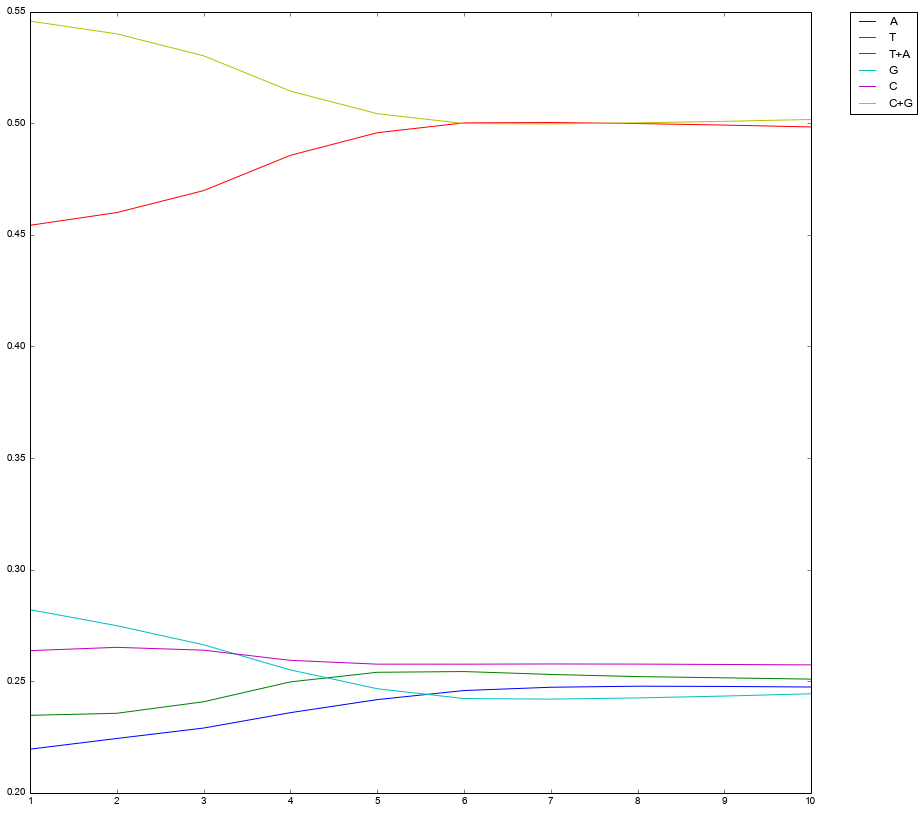

In [303]:
plt.figure(figsize=(14, 14), dpi=500)
plt.plot(np.arange(10)+1,freq_right_A,label=u"A")
plt.plot(np.arange(10)+1,freq_right_T,label=u"T")
plt.plot(np.arange(10)+1,freq_right_T+freq_right_A,label=u"T+A")
plt.plot(np.arange(10)+1,freq_right_G,label=u"G")
plt.plot(np.arange(10)+1,freq_right_C,label=u"C")
plt.plot(np.arange(10)+1,freq_right_C+freq_right_G,label=u"C+G")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
samfile = pysam.AlignmentFile("/home/alexgri/Desktop/indels/GoldenStandard_OurAlgorithms/gcat_set_059-ready.bam", "rb")
#for read in samfile.fetch('1', 1019890, 1019891):
#     print read


for pileupcolumn in samfile.pileup('1', pos, pos+1):
    if (pileupcolumn.pos==pos or pileupcolumn.pos==pos+1 or pileupcolumn.pos==pos-1):
        print ("\ncoverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            #print pileupread.alignment.seq
            if not pileupread.is_del and not pileupread.is_refskip and (pos-pileupread.alignment.pos>=0) and (pos-pileupread.alignment.pos<len(pileupread.alignment.seq)):
                print ('\tbase in read %s = %s' %(pileupread.alignment.query_name,pileupread.alignment.query_sequence[pos - pileupread.alignment.pos]))
samfile.close()